In [1]:
from BACKGROUND_PYTHON_SCRIPTS.Functions_DischargeEstimation import *
from BACKGROUND_PYTHON_SCRIPTS.my_functions import *

<div style="background-color: lightblue; padding: 10px 0;">
    <h1 style="text-align: center; font-style: italic; margin: 0;">Manning & Leopold methods to estimate discharge</h1>
</div>

</br>
This notebok is a set up to work with Manning & Leopold. This is a method, which can be seen as an alternative to the modelling method, that was used in the accomponying manual. This could be a promosing path that needs some further exploration. This notebook gives some tools to do just that. Theoretical explanations on the methods can be found in Chapter 5.1 and Appendix I of the manual. Unfortunately, the results for the case study in the Enkare Narok river were non-conclusive. Hence, the method is not further utilized in the methodology.

<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Importing Data</h2>
</div>

</br>

To use this notebook, input data is needed. The input consists out of:
* Hydraulic parameters of the normal state (low water);
* Hydraulic parameters of the bankfull state.

Therefore, it is required to have run at least the following notebooks before starting with this one:
* RUN_THIS_NOTEBOOK.ipynb (Data Processor Package) --> To obtain hydraulic parameters of the normal state;
* SLOPE_DETERMINATION_ipynb (Data Processor Package) --> To obtain local slopes of the cross sections;
* BANKFULL.ipynb --> To obtain hydraulic parameters of the bankfull state.

The input for this notebook should be provided in the file "ManningLeopold.xlsx", which can be found in the same folder as this notebook.

In [2]:
hydraulic_parameters_low = pd.read_excel('./ManningLeopold.xlsx', sheet_name='Hydraulic_parameters')
hydraulic_parameters_bf = pd.read_excel(f'./ManningLeopold.xlsx', sheet_name='Bankfull', skiprows=1)

In [3]:
width = hydraulic_parameters_low['width [m]']                
depth_average = hydraulic_parameters_low['mean_depth [m]']    
area = hydraulic_parameters_low['flow_area [m2]']     
hydraulic_radius = hydraulic_parameters_low['hydraulic_radius [m]'] 
velocity_average = hydraulic_parameters_low['average_velocity [m/s]']  
slope = hydraulic_parameters_low['slope']                  

<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Manning Equation</h2>
</div>

In [8]:
# Determine Manning coefficient for the measured average velocities
n = calculate_Manningcoefficient(hydraulic_radius, slope, velocity_average)
hydraulic_parameters_low['Manning_n'] = n
n_mean = hydraulic_parameters_low['Manning_n'].mean()
n_literature = 0.05
n_used = n_mean

hydraulic_parameters_bf['Bankfull_discharge[m3/s]'] = calculate_discharge_Manning(hydraulic_parameters_bf['area [m2]'], 
                                                                                  n_used, 
                                                                                  hydraulic_parameters_bf['hydraulic_radius [m]'], 
                                                                                  hydraulic_parameters_low['slope'])
hydraulic_parameters_bf['Bankfull_flow_velocity[m/s]'] = calculate_velocity_Manning(n_used, 
                                                                                    hydraulic_parameters_bf['hydraulic_radius [m]'], 
                                                                                    hydraulic_parameters_low['slope'])

In [9]:
# Calculate discharge using Manning equation for every cross-section, for the bank full state (use dataFlood)
Q_bf_Mann = calculate_discharge_Manning(hydraulic_parameters_bf['area [m2]'], n_used, hydraulic_parameters_bf['hydraulic_radius [m]'], hydraulic_parameters_low['slope'])

print(f'Manning bank full discharge, in m3/s: {Q_bf_Mann}')

Manning bank full discharge, in m3/s: 0     0.789574
1     0.553556
2    12.700920
3    29.240103
4    26.529109
5    84.434932
6    67.855933
7    35.546980
dtype: float64


In [10]:
# Calculate mean discharge over the river reach
Q_bf_Mann_mean = Q_bf_Mann.mean() 
print(f'Mean discharge for bank full state of the river, based on Manning equation: {Q_bf_Mann_mean:.3f} m3/s')

Mean discharge for bank full state of the river, based on Manning equation: 32.206 m3/s


In [12]:
v_bf_Mann = calculate_velocity_Manning(n_used, hydraulic_parameters_bf['hydraulic_radius [m]'], hydraulic_parameters_low['slope'])

print(f'flow velocity per cross-section, for bank full state, in m/s: {v_bf_Mann}')

flow velocity per cross-section, for bank full state, in m/s: 0    0.141601
1    0.366055
2    0.351489
3    0.521391
4    0.557853
5    1.337246
6    1.013759
7    1.316863
dtype: float64


In [13]:
# Calculate mean velocity over the river reach
v_bf_Mann_mean = v_bf_Mann.mean() 
print(f'Mean flow velocity for bank full state of the river, based on Manning equation: {v_bf_Mann_mean:.3f} m/s')

Mean flow velocity for bank full state of the river, based on Manning equation: 0.701 m/s


<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Leopold & Maddock method</h2>
</div>

</br>
Two methods are given to determine the Leopold parameters, as is explained in Appendix I of the manual. It is recommended to use method 2. 

The first method follows the original method explained by Leopold and Maddock, and is useful to give a first indication of the relations, based on the logarithmic plots. 
In these plots, a linear relation should be visible. Outstanding points, that are probably off due to irregularities of the river bank, or measurement errors, can be easily identified here. It is recommended to remove these out of the dataset, to find a correct relation. 

The second method determines all six parameters right away, based on the non-linear relation it should have. The result will slightly differ, and is assumed to be more reliable. 
However, the results are a bit more difficult to analyze, and 'outstanding' points are harder to identify. 

In [15]:
# Apply Leopold & Maddock method to bank full states of the river, and calculated discharges and velocities based on Manning
# If any cross-sections cleary stand out, remove them of the data, by selecting the suitable cross-sections (for example width = width_bf[[1, 2, 4, 5, 6, 9]])

width = hydraulic_parameters_low['width [m]']
depth = hydraulic_parameters_low['hydraulic_radius [m]']            # Use hydraulic radius as the depth geometry
velocity = v_bf_Mann
Q = Q_bf_Mann

### Method 1

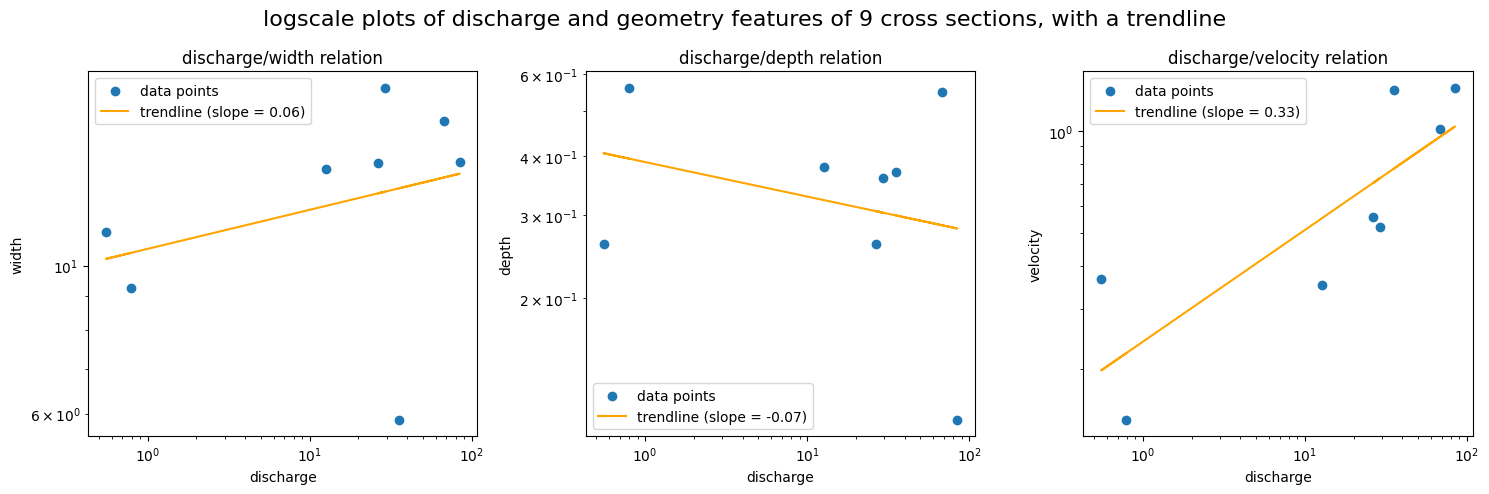

b: 0.058
f: -0.073
m: 0.329


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Create scatter plots on a log-log scale (Q on x-axis)
ax[0].scatter(Q, width, label='data points')
ax[1].scatter(Q, depth, label='data points')
ax[2].scatter(Q, velocity, label='data points')

# Fit a trendline to the original data in log-log space (swapping x and y)
coeff_width = np.polyfit(np.log10(Q), np.log10(width), 1)  # 1st degree polynomial on log-log data
slope_width, intercept_width = coeff_width
coeff_depth = np.polyfit(np.log10(Q), np.log10(depth), 1)  # 1st degree polynomial on log-log data
slope_depth, intercept_depth = coeff_depth
coeff_velocity = np.polyfit(np.log10(Q), np.log10(velocity), 1)  # 1st degree polynomial on log-log data
slope_velocity, intercept_velocity = coeff_velocity

# Create the trendline using the original Q values (swapping axes)
trendline_width = 10**(slope_width * np.log10(Q) + intercept_width)
trendline_depth = 10**(slope_depth * np.log10(Q) + intercept_depth)
trendline_velocity = 10**(slope_velocity * np.log10(Q) + intercept_velocity)
ax[0].plot(Q, trendline_width, label=f"trendline (slope = {slope_width:.2f})", color="orange")
ax[1].plot(Q, trendline_depth, label=f"trendline (slope = {slope_depth:.2f})", color="orange")
ax[2].plot(Q, trendline_velocity, label=f"trendline (slope = {slope_velocity:.2f})", color="orange")

# Log scale for both axes
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')

# Labels and legend
ax[0].set_xlabel('discharge')
ax[0].set_ylabel('width')
ax[0].set_title('discharge/width relation')
ax[0].legend()
ax[1].set_xlabel('discharge')
ax[1].set_ylabel('depth')
ax[1].set_title('discharge/depth relation')
ax[1].legend()
ax[2].set_xlabel('discharge')
ax[2].set_ylabel('velocity')
ax[2].set_title('discharge/velocity relation')
ax[2].legend()
fig.suptitle('logscale plots of discharge and geometry features of 9 cross sections, with a trendline', fontsize=16)
fig.subplots_adjust(top=0.85)

# Show plot
plt.tight_layout()
plt.show()

b1, f1, m1 = slope_width, slope_depth, slope_velocity

# Print the slope of the trendline
print(f'b: {slope_width:.3f}')
print(f'f: {slope_depth:.3f}')
print(f'm: {slope_velocity:.3f}')

In [17]:
a1, c1, k1 = calculate_multipliers_Leopold_Method1(slope_width, slope_depth, slope_velocity, width, depth, velocity, Q)
print(f'Calculated mean values for a, c, k: {a1:.3f}, {c1:.3f}, {k1:.3f}')

Calculated mean values for a, c, k: 11.084, 0.429, 0.261


### Method 2

Fitted equations:
width = 10.5970 * Q^0.0585
depth = 0.3892 * Q^-0.0735
velocity = 0.2397 * Q^0.3285


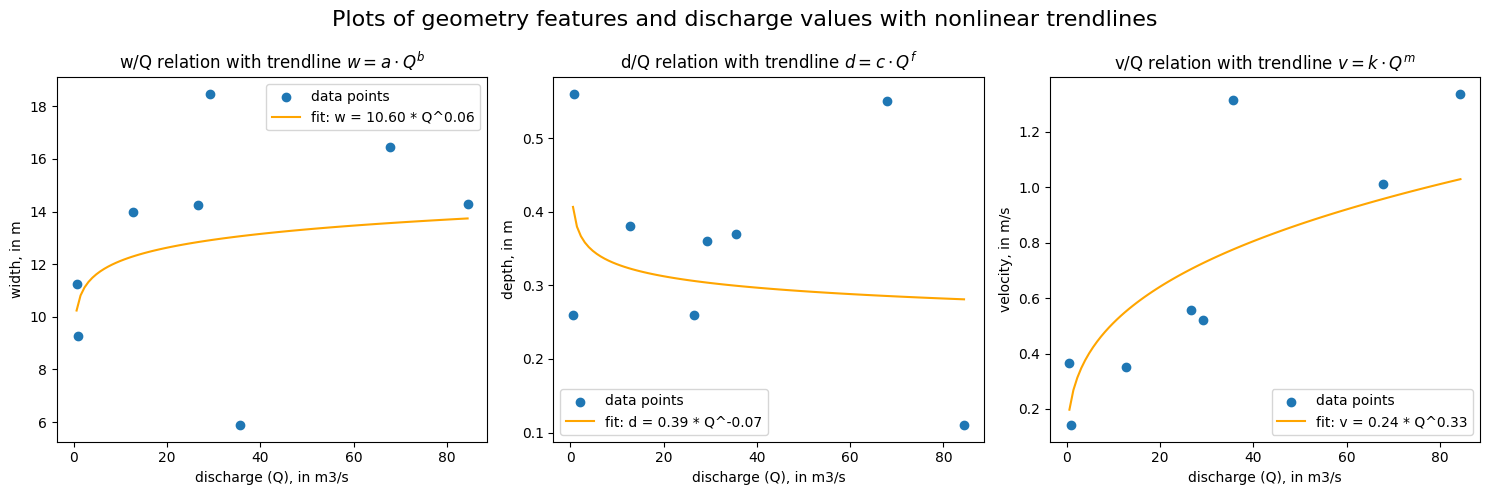

<Figure size 640x480 with 0 Axes>

In [18]:
# Nonlinear function for fitting: a = x * Q^y
def nonlinear_model(Q, x, y):
    return x * Q ** y

log_Q = np.log(Q)
log_width = np.log(width)
log_depth = np.log(depth)
log_velocity = np.log(velocity)

# Step 2: Perform linear fit on log-transformed data
slope, intercept = np.polyfit(log_Q, log_width, 1)
b = slope
a = np.exp(intercept)
slope, intercept = np.polyfit(log_Q, log_depth, 1)
f = slope
c = np.exp(intercept)
slope, intercept = np.polyfit(log_Q, log_velocity, 1)
m = slope
k = np.exp(intercept)

# Print the results
print(f'Fitted equations:') 
print(f'width = {a:.4f} * Q^{b:.4f}')
print(f'depth = {c:.4f} * Q^{f:.4f}')
print(f'velocity = {k:.4f} * Q^{m:.4f}')

# Create fitted curves
Q_fit = np.linspace(min(Q), max(Q), 100)
width_fit = a * Q_fit**b
depth_fit = c * Q_fit**f
velocity_fit = k * Q_fit**m


# Create the plots (normal scale)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plots with nonlinear trendlines
ax[0].scatter(Q, width, label='data points')
ax[0].plot(Q_fit, width_fit, color='orange', label=f'fit: w = {a:.2f} * Q^{b:.2f}')
ax[0].set_xlabel('discharge (Q), in m3/s')
ax[0].set_ylabel('width, in m')
ax[0].set_title(r'w/Q relation with trendline $w = a \cdot Q^b$')
ax[0].legend()

ax[1].scatter(Q, depth, label='data points')
ax[1].plot(Q_fit, depth_fit, color='orange', label=f'fit: d = {c:.2f} * Q^{f:.2f}')
ax[1].set_xlabel('discharge (Q), in m3/s')
ax[1].set_ylabel('depth, in m')
ax[1].set_title(r'd/Q relation with trendline $d = c \cdot Q^f$')
ax[1].legend()

ax[2].scatter(Q, velocity, label='data points')
ax[2].plot(Q_fit, velocity_fit, color='orange', label=f'fit: v = {k:.2f} * Q^{m:.2f}')
ax[2].set_xlabel('discharge (Q), in m3/s')
ax[2].set_ylabel('velocity, in m/s')
ax[2].set_title(r'v/Q relation with trendline $v = k \cdot Q^m$')
ax[2].legend()

# Set the main title and adjust layout
fig.suptitle('Plots of geometry features and discharge values with nonlinear trendlines', fontsize=16)
fig.subplots_adjust(top=0.85)
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
plt.savefig('Fitted_Leopold_parameters_plot.png')

In [19]:
# Print the parameters for the nonlinear trendlines
print(f'Width model: a = {a:.3f}, b = {b:.3f}')
print(f'Depth model: c = {c:.3f}, f = {f:.3f}')
print(f'Velocity model: k = {k:.3f}, m = {m:.3f}')

Width model: a = 10.597, b = 0.058
Depth model: c = 0.389, f = -0.073
Velocity model: k = 0.240, m = 0.329


### Checking the conditions
The Leopold parameters should satisfy three equations, determined by Leopold & Maddock. The equations are given in Appendix H of the manual. 
A check is done here. 

- The first check (Q_check), looks at the correctness of the discharge. It should approximately satisfy Q = v * A, for every cross-section. 
- The second check (powers_check), looks at the relation of the parameters b, f, and m, which should together be equal to 1. 
- The third check (multipliers_check), looks at the relation of the parameters a, c, and k, which should together multiply to 1. 

All checks should give the outcome True. The tolerance of the checks can be edited, and is now given at 20% (0.2). 

In [20]:
Q_check, powers_check, multipliers_check = check_Leopold_parameters(width, depth, velocity, Q, b, f, m, a, c, k, 0.2)
print(Q_check, powers_check, multipliers_check)

[ True False False False False False False False] False True


### Calculate mean discharge in the river reach, based on Leopold & Maddock

In [21]:
Q_bf_Leopold_width, Q_bf_Leopold_depth, Q_bf_Leopold_velocity, Q_bf_Leopold_average = calculate_Leopold_discharge(width, depth, velocity, a, c, k, b, f, m)
print(f'Discharge per cross-section, averaged for all three relations, in m3/s: {Q_bf_Leopold_average}')

Discharge per cross-section, averaged for all three relations, in m3/s: 0    1.026927e-01
1    8.288338e+01
2    3.908380e+01
3    4.450369e+03
4    1.384800e+02
5    9.814689e+06
6    6.534803e+02
7    6.020083e+01
dtype: float64


In [22]:
print(f'Discharge per cross-section, for all three relations, in m3/s: {Q_bf_Leopold_width, Q_bf_Leopold_depth, Q_bf_Leopold_velocity}')

Discharge per cross-section, for all three relations, in m3/s: (0        0.099678
1        2.737522
2      112.662450
3    13337.573147
4      160.078519
5      167.931096
6     1879.875152
7        0.000042
Name: width [m], dtype: float64, 0    7.064321e-03
1    2.422861e+02
2    1.384073e+00
3    2.889025e+00
4    2.422861e+02
5    2.944371e+07
6    9.027721e-03
7    1.989736e+00
Name: hydraulic_radius [m], dtype: float64, 0      0.201336
1      3.626529
2      3.204881
3     10.643736
4     13.075346
5    187.162124
6     80.556708
7    178.612714
dtype: float64)
